# Notebook 10: XGBoost, Gradient Boosted Trees, and SUSY

## Learning Goal
The goal of this notebook is to familiarize the reader with the powerful package XGBoost for constructing gradient boosted trees. We will discuss how to visualize feature importances as well as techniques for optimizing XGBoost.

## Overview

In this notebook, we will focus on using Gradient Boosted Trees (in particular XGBoost) to classify the supersymmetry (SUSY) dataset, first introduced by [Baldi et al. Nature Communication 2015 and Arxiv:1402.4735](https://arxiv.org/pdf/1402.4735.pdf). The supersymmetry data set consists of 5,000,000 Monte-Carlo samples of supersymmetric and non-supersymmetric collisions with 18 features. The signal process is the production of electrically-charged
supersymmetric particles which decay to W bosons and an electrically-neutral supersymmetric
particle that is invisible to the detector. 

The first 8 features are "raw" (low-level) kinematic features that can be directly measured from collisions. The final 10 features are "hand constructed" (high-level) features that have been chosen using physical knowledge, and are known to be important in distinguishing supersymmetric and non-supersymmetric collision events. More specifically, they are given by the column names below.

We will drawn upon the useful [blog posts](https://jessesw.com/XG-Boost/)
that compactly introduces many of the basics of hyperparameter tuning. As we will see, there are many practical trade-offs we have to worry about. Unlike Random Forests, for more complicated algorithms such as XGBoost, overfitting can be a major worry. It is also extremely computationally expensive to do hyperparameter searches. However, this notebook should get you started on these interesting methods.

## Downloading the SUSY dataset
The supersymmetry dataset can be downloaded from the UCI Machine Learning repository on [https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz](https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz). The dataset is quite large. Download the dataset and unzip it in a directory. We will be using this dataset with gradient boosted trees. We will focus on the XGBoost aglorithm.

## Installing XGBoost

If you have not already done so, you will also have to install the XGBoost python package, see e.g. [https://github.com/dmlc/xgboost/tree/master/python-package](https://github.com/dmlc/xgboost/tree/master/python-package). The easiest way to do this is to clone the Github repository, navigate to this directory, and
use the pip command: <span style="background-color:yellow">pip install xgboost</span>. Alternatively, one can use Anacodna: <span style="background-color:yellow">conda install -c conda-forge xgboost</span>. 

## Load in dataset and construct training and test set

In [1]:
#Load the dataset using pandas and numpy
import sys, os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

#Filename [CHANGE THIS TO YOUR FILENAME FOR SUSY]
filename=os.path.expanduser('~')+'/ML_review/SUSY_data/SUSY.csv' 

#Read in SUSY File. We will only work with subset of data for demonstration purposes.

features=['SUSY','lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 
 'missing energy magnitude', 'missing energy phi', 'MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2', 
 'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']

low_features=['lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 
 'missing energy magnitude', 'missing energy phi']

high_features=['MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2','S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']

#Number of datapoints to work with
N = 100000
print("Size of dataset : %i"%N)
df = pd.read_csv(filename, header=None,nrows=N,engine='python')
df.columns=features
y = df['SUSY'].values
X = df[[col for col in df.columns if col!="SUSY"]]

#Make datasets using only the 8 low-level features and 10 high-level features
X_low=X[low_features]
X_high=X[high_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=0)
X_low_train, X_low_test, y_low_train, y_low_test = train_test_split(X_low, y, test_size=.1, random_state=0)
X_high_train, X_high_test, y_high_train, y_high_test = train_test_split(X_high, y, test_size=.1, random_state=0)

Size of dataset : 100000


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\92412/ML_review/SUSY_data/SUSY.csv'

# Train and test models

In [2]:
# For next cell
from sklearn.metrics import roc_auc_score
import time
import xgboost as xgb
import warnings

warnings.filterwarnings(action='ignore', category=DeprecationWarning)

print("Training on %i examples with %i features"%X_train.shape)

#Use default parameters and train on full dataset
XGBclassifier = xgb.sklearn.XGBClassifier(nthread=-1, seed=1, n_estimators=1000)
#Train and time classifier
start_time = time.time()
XGBclassifier.fit(X_train, y_train)
run_time = time.time() - start_time

#Make Predictions
print("Predicting on %i examples with %i features\n"%X_test.shape)
y_pred= XGBclassifier.predict(X_test)

#Print Results
print("Model Accuracy with all features: {:.2f}%".format(100*XGBclassifier.score(X_test, y_test)))
print("The AUC score with all features is {:.2f}".format(roc_auc_score(y_test,y_pred)))
print("Run time with all features: {:.2f} sec\n\n".format(run_time))


#Rerun with just low-level kinematic features with default parameters

print("Training on %i examples with %i features"%X_low_train.shape)
XGBclassifier_low = xgb.sklearn.XGBClassifier(nthread=-1, seed=1)
#Train and time classifier
start_time = time.time()
XGBclassifier_low.fit(X_low_train, y_low_train)
run_time = time.time() - start_time

#Make Predictions
print("Predicting on %i examples with %i features\n"%X_low_test.shape)
y_low_pred = XGBclassifier_low.predict(X_low_test)

#Print Results
print("Model Accuracy with just low-level kinematic features: {:.2f}%".format(100*XGBclassifier_low.score(X_low_test, y_low_test)))
print("The low-level AUC score is {:.2f}".format(roc_auc_score(y_test,y_low_pred)))
print("Run time with low-level features: {:.2f} sec\n\n".format(run_time))


#Rerun with just high-level kinematic features with default parameters

print("Training on %i examples with %i features\n"%X_high_train.shape)
XGBclassifier_high = xgb.sklearn.XGBClassifier(nthread=-1, seed=1)
#Train and time classifier
start_time = time.time()
XGBclassifier_high.fit(X_high_train, y_high_train)
run_time = time.time() - start_time

print("Training on %i examples with %i features"%X_high_test.shape)
#Make Predictions
y_high_pred = XGBclassifier_high.predict(X_high_test)

#Print Results
print("Model Accuracy with just high-level features: {:.2f}%".format(100*XGBclassifier_low.score(X_low_test, y_low_test)))
print("The high-level AUC score is {:.2f}".format(roc_auc_score(y_test,y_high_pred)))
print("Run time with high-level features: {:.2f} sec\n\n".format(run_time))

ModuleNotFoundError: No module named 'xgboost'

## Visualizing Feature Importance

One nice aspect of XGBoost (and ensemble methods in general) is that it is easy to visualize feature importances. In XGBoost, there are some handy plots for viewing these (similar functions also exist for the scikit implementation of random forests). One thing we can calculate is the feature importance score (Fscore), which measures how many times each feature was split on. The higher this number, the more fine-tuned the partitions in this direction, and presumably the more informative it is for our classification task.


In [ ]:
#import ml_style as style
import matplotlib as mpl
#mpl.rcParams.update(style.style)
import matplotlib.pyplot as plt


%matplotlib inline  

fig=plt.figure()
xgb.plot_importance(XGBclassifier, ax=plt.gca())
fig.subplots_adjust(left=0.4)  #
#fig.savefig('SUSYXGBoost1.pdf')

fig=plt.figure()
xgb.plot_importance(XGBclassifier_low, ax=plt.gca())
fig.subplots_adjust(left=0.4)
#fig.savefig('SUSYXGBoost2.pdf')
fig=plt.figure()
xgb.plot_importance(XGBclassifier_high, ax=plt.gca())
fig.subplots_adjust(left=0.4)
#fig.savefig('SUSYXGBoost3.pdf')


## Plot ROC curves

This simple example shows that with the default parameters one can already achieve an accuracy of about 80 percent using all the features (kinematic and hand crafted), and a slightly smaller accuracy of about 78.75% using just the kinematic features.  Both achieve a very respectable AUC (area under the ROC curve, see [https://en.wikipedia.org/wiki/Receiver_operating_characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)) score of around 0.78 or 0.79. This is significantly better than that achieved using Boosted Decision Trees (though not deep neural networks) in the original [paper](https://www.nature.com/articles/ncomms5308), even without tuning hyperparameters. Furthermore, we are using only a small subset of all the data (100,000 out of a total of 5,000,000 datapoints) so this performance is a lower bound on what can be accomplished with XGBoost. Note that there are only three points on the curve so the ROC does not contain much information beyond the accuracy.

We can summarize this by plotting the ROC curves for these three models. Recall that ROC curves plot the true positive rate. Here, we will use the modified version used in high-energy physics plotting the true negative rate (Background rejection) against the true positive rate (signal efficiency).


In [ ]:
from sklearn.metrics import roc_curve


%matplotlib inline  

fpr, tpr, _ = roc_curve(y_test, y_pred)
fpr_low, tpr_low, _ = roc_curve(y_test, y_low_pred)
fpr_high, tpr_high, _ = roc_curve(y_test, y_high_pred)
plt.figure(1)
plt.plot(tpr, 1-fpr, label='Full')
plt.plot(tpr_low, 1-fpr_low, label='Low')
plt.plot(tpr_high, 1-fpr_high, label='High')
plt.legend(loc=1)
plt.xlabel('Signal efficiency')
plt.ylabel('Background Rejection')
plt.savefig("SUSY_roc_XGBoost.pdf")



## Optimizing XGBoost

We will now optimize the parameters of the XGBoost algorithm by performing a grid search. We will use the very useful new function from scikit-learn `GridSearchCV()`. This function allows you to specify lists of parameters to search over.

Let us briefly discuss what parameters we can tune to improve performance with descriptions:

* `max_depth` [default=6]: maximum depth of a tree, increasing this value will make the model more complex / likely to overfit.

* `eta` or 'learning_rate'[default =0.3]: step size shrinkage used in update to prevent overfitting. After each boosting step, we can directly get the weights of new features. `eta` actually shrinks the feature weights to make the boosting process more conservative.

* `gamma` or min-split-loss [default=0]: This is the penalty that regularizes the number of leaves. The larger, the more conservative the algorithm will be. 

* `min_child_weight` [default=1]: In linear regression mode, this simply corresponds to the minimum number of instances needed to be in each node (min $B_j$ in notation of manuscript). The larger, the more conservative the algorithm will be. More generally, it is the minimum sum of instance weight (Hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. 


As you can see this cross-validation procedure is quite computationally expensive. With the parameters below, it takes somewhere between 2 and 5 minutes on a powerful laptop. In the cell below, we perform the search and examine the results in the subsequent results.

In [ ]:
from sklearn.model_selection import GridSearchCV 

#Create values to search over
cv_params = {'max_depth': [3,4,6], 'min_child_weight': [1,3,5], 'learning_rate':[0.1,0.3]}
ind_params = {'n_estimators': 100, 'seed':1, 'colsample_bytree': 1, 
             'objective': 'binary:logistic'}
opt_XGBclassifier = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1, verbose=3)

opt_XGBclassifier.fit(X_train, y_train)
opt_XGBclassifier.cv_results_

In [ ]:
#Print scores
print('The optimal score on training set is {:0.3f}'.format(opt_XGBclassifier.best_score_))

#Find optimal parameters

print('The optimal parameters for the classifier are:')
print(opt_XGBclassifier.best_params_)

#Fit performance on the test set
XGBclassifier_final=opt_XGBclassifier.best_estimator_
y_pred_final=XGBclassifier_final.predict(X_test)
print("Model Accuray with optimal parameters: {:.2f}%".format(100*XGBclassifier_final.score(X_test, y_test)))
print("The  AUC score is {:.2f}".format(roc_auc_score(y_test,y_pred_final)))


## Further Optimization: early stopping and computational efficiency

We see that we have slightly improved our performance. The default parameters work pretty well. Here, we have used relatively small ensembles (100) to make things faster. In practice, it is worth using much bigger ensembles, in which case overfitting and optimization are likely to have larger effects.

# Following this very nice blog post, [https://jessesw.com/XG-Boost/](https://jessesw.com/XG-Boost/), we can do some further optimization of the XGBoost algorithm. Part of this is computational and has to do with how we interface with XGBoost, and part will be due to another regularization technique that we discussed in the gradient descent chapter: *early stopping*. Early stopping is now considered one of the most important regularization techniques. The basic idea behind it is to just stop the gradient descent once some measure of error stops going down significantly. 

You are invited to play with the code and experiment with this yourself.


ADR: largely descriptive.

<b> Somehow, the code run on my computer have a different result from the original one. Don't know why, but this is not the first time happened

# Monte carlo to find optimal parameters 

<b> I think for optimizing the XGBoost, we can use Monte carlo to examine the hyperparameters. Since my shitty computer running too slow on the Gridsearch. And maybe thus we can examine a big range of number of parameter and vote which one is perform best. 

Another reason doing this is because by gridsearch increasing number of candidates, the possible conbination will increasing exponentially. Which make its impossible to search in a larger range, thus narrow our accuracy in the initial level.

In [3]:

t = 0
max_depth_lis = np.arange(3,10,1)
min_weight_lis = np.arange(1,10,1)
learning_rate = np.arange(0.05,0.3,0.05)
while t <= 10: 
    t += 1 
    
    cv_params = {'max_depth': [np.random.choice(max_depth_lis)], 'min_child_weight': [np.random.choice(min_weight_lis)], 'learning_rate':[np.random.choice(learning_rate)]}
    ind_params = {'n_estimators': 100, 'seed':1, 'colsample_bytree': 1, 
                 'objective': 'binary:logistic'}
    opt_XGBclassifier = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                                cv_params, 
                                 scoring = 'accuracy', cv = 5, n_jobs = -1, verbose=3)

    opt_XGBclassifier.fit(X_train, y_train)
    XGBclassifier_final=opt_XGBclassifier.best_estimator_
    #opt_XGBclassifier.cv_scores_
    print('current parameters:',opt_XGBclassifier.best_params_)
    print("Model Accuray with current parameters: {:.2f}%".format(100*XGBclassifier_final.score(X_test, y_test)))
    

NameError: name 'GridSearchCV' is not defined

<b> Bam!! we find a much better parameter set which is 'learning_rate' = 0.1, 'max_depth' = 6, 'min_child_weight' = 7, with a 79.94% accuracy!! 
    
    

In [24]:

t = 0
max_depth_lis = np.arange(3,10,1)
min_weight_lis = np.arange(1,10,1)
learning_rate = np.arange(0.05,0.3,0.05)
while t <= 20: 
    t += 1 
    
    cv_params = {'max_depth': [np.random.choice(max_depth_lis)], 'min_child_weight': [np.random.choice(min_weight_lis)], 'learning_rate':[np.random.choice(learning_rate)]}
    ind_params = {'n_estimators': 100, 'seed':1, 'colsample_bytree': 1, 
                 'objective': 'binary:logistic'}
    opt_XGBclassifier = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                                cv_params, 
                                 scoring = 'accuracy', cv = 5, n_jobs = -1, verbose=3)

    opt_XGBclassifier.fit(X_train, y_train)
    XGBclassifier_final=opt_XGBclassifier.best_estimator_
    #opt_XGBclassifier.cv_scores_
    print('current parameters:',opt_XGBclassifier.best_params_)
    print("Model Accuray with current parameters: {:.2f}%".format(100*XGBclassifier_final.score(X_test, y_test)))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
current parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 9}
Model Accuray with current parameters: 79.57%
Fitting 5 folds for each of 1 candidates, totalling 5 fits
current parameters: {'learning_rate': 0.15000000000000002, 'max_depth': 3, 'min_child_weight': 1}
Model Accuray with current parameters: 79.46%
Fitting 5 folds for each of 1 candidates, totalling 5 fits
current parameters: {'learning_rate': 0.15000000000000002, 'max_depth': 8, 'min_child_weight': 7}
Model Accuray with current parameters: 79.77%
Fitting 5 folds for each of 1 candidates, totalling 5 fits
current parameters: {'learning_rate': 0.15000000000000002, 'max_depth': 7, 'min_child_weight': 9}
Model Accuray with current parameters: 79.62%
Fitting 5 folds for each of 1 candidates, totalling 5 fits
current parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 9}
Model Accuray with current parameters: 78.88%
Fitting 5 folds 

In [24]:
from sklearn.model_selection import GridSearchCV 
t = 0
max_depth_lis = np.arange(5,8,1)
min_weight_lis = np.arange(2,8,1)
learning_rate = np.arange(0.08,0.15,0.01)
while t <= 30: 
    t += 1 
    
    cv_params = {'max_depth': [np.random.choice(max_depth_lis)], 'min_child_weight': [np.random.choice(min_weight_lis)], 'learning_rate':[np.random.choice(learning_rate)]}
    ind_params = {'n_estimators': 100, 'seed':1, 'colsample_bytree': 1, 
                 'objective': 'binary:logistic'}
    opt_XGBclassifier = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                                cv_params, 
                                 scoring = 'accuracy', cv = 5, n_jobs = -1, verbose=3)

    opt_XGBclassifier.fit(X_train, y_train)
    XGBclassifier_final=opt_XGBclassifier.best_estimator_
    #opt_XGBclassifier.cv_scores_
    print('current parameters:',opt_XGBclassifier.best_params_)
    print("Model Accuray with current parameters: {:.2f}%".format(100*XGBclassifier_final.score(X_test, y_test)))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
current parameters: {'learning_rate': 0.10999999999999999, 'max_depth': 5, 'min_child_weight': 3}
Model Accuray with current parameters: 79.76%
Fitting 5 folds for each of 1 candidates, totalling 5 fits
current parameters: {'learning_rate': 0.08, 'max_depth': 5, 'min_child_weight': 3}
Model Accuray with current parameters: 79.61%
Fitting 5 folds for each of 1 candidates, totalling 5 fits
current parameters: {'learning_rate': 0.09, 'max_depth': 6, 'min_child_weight': 4}
Model Accuray with current parameters: 79.76%
Fitting 5 folds for each of 1 candidates, totalling 5 fits
current parameters: {'learning_rate': 0.09, 'max_depth': 6, 'min_child_weight': 3}
Model Accuray with current parameters: 79.71%
Fitting 5 folds for each of 1 candidates, totalling 5 fits
current parameters: {'learning_rate': 0.12999999999999998, 'max_depth': 6, 'min_child_weight': 2}
Model Accuray with current parameters: 79.72%
Fitting 5 folds for each of 1 

KeyboardInterrupt: 

<b>with 'learning_rate': 0.12, 'max_depth': 6, 'min_child_weight': 3}, we even reached 80.03%

# Implement early stopping and subsample on SUSY 

In [20]:
xgdmat_susy = xgb.DMatrix(X_train, y_train) # Create our DMatrix to make XGBoost more efficient
our_params = {'eta': 0.1, 'seed':1, 'subsample': 0.8, 'colsample_bytree': 1, 
             'objective': 'binary:logistic', 'max_depth':7, 'min_child_weight':3} 
# Grid Search CV optimized settings

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat_susy, num_boost_round = 100, nfold = 5,
                metrics = ['error'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 100) # Look for early stopping that minimizes error

In [22]:
cv_xgb.tail(5)

,train-error-mean,train-error-std,test-error-mean,test-error-std
95,0.177525,0.000648,0.202967,0.003532
96,0.177303,0.000617,0.203089,0.003482
97,0.177136,0.000698,0.203233,0.003514
98,0.176883,0.000666,0.203145,0.003377
99,0.176744,0.000729,0.203167,0.003266


In [25]:
100*(1-0.202967)

79.7033

<b> 79.7%. The accuracy is even lower than the result from Monte carlo

In [19]:
our_params = {'eta': 0.1, 'seed':1, 'subsample': 0.8, 'colsample_bytree': 1, 
             'objective': 'binary:logistic', 'max_depth':7, 'min_child_weight':3} 

final_gb = xgb.train(our_params, xgdmat_susy, num_boost_round = 100)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

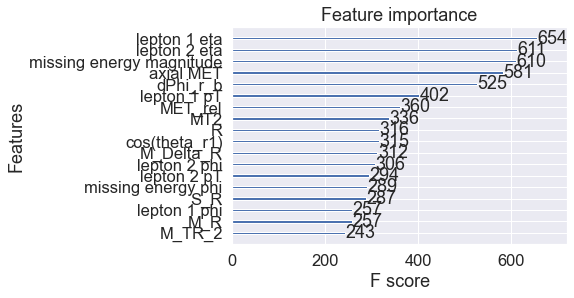

In [21]:
%matplotlib inline
import seaborn as sns
sns.set(font_scale = 1.5)
xgb.plot_importance(final_gb)

<b> Its seems early stopping doesn't help on the SUSY, or maybe I do in the wrong way.

# What I learned

<b> The big lesson in this notebook is optimization. We can really do a lot of thing to give the original method a better performance. 

Method like extrem randomization, subsample, early stopping, optimal parameters search. However, not all methods working on the same data, like early stopping doesn't help on the SUSY. Subsample doesn't help on the wage data. We have to try each method and do the note. 

XGboost use a integrated regularizaion to do gradient boost trees and have a higher efficient. 
    
Feature importance plot is very useful tool for us to manually sort the features. And probably by manually adjust the weight of feature we can have a even better accuracy. 

# Following the code from Blog 

<b> The guide is so detailed I think this is a great chance to practice. 

In [25]:
import numpy as np
import pandas as pd

In [26]:
train_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None)
test_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',
                      skiprows = 1, header = None) # Make sure to skip a row for the test set

In [27]:
train_set.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [28]:
test_set.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [29]:
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']

In [30]:
train_set.columns = col_labels
test_set.columns = col_labels

In [31]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  wage_class      32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [32]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16281 non-null  int64 
 1   workclass       16281 non-null  object
 2   fnlwgt          16281 non-null  int64 
 3   education       16281 non-null  object
 4   education_num   16281 non-null  int64 
 5   marital_status  16281 non-null  object
 6   occupation      16281 non-null  object
 7   relationship    16281 non-null  object
 8   race            16281 non-null  object
 9   sex             16281 non-null  object
 10  capital_gain    16281 non-null  int64 
 11  capital_loss    16281 non-null  int64 
 12  hours_per_week  16281 non-null  int64 
 13  native_country  16281 non-null  object
 14  wage_class      16281 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


In [35]:
train_set.replace(' ?', np.nan).dropna().shape 

(30162, 15)

In [36]:
test_set.replace(' ?', np.nan).dropna().shape

(15060, 15)

In [37]:
train_nomissing = train_set.replace(' ?', np.nan).dropna()
test_nomissing = test_set.replace(' ?', np.nan).dropna()

In [38]:
test_nomissing['wage_class'] = test_nomissing.wage_class.replace({' <=50K.': ' <=50K', ' >50K.':' >50K'})

In [39]:
test_nomissing.wage_class.unique()

array([' <=50K', ' >50K'], dtype=object)

In [40]:
train_nomissing.wage_class.unique()

array([' <=50K', ' >50K'], dtype=object)

In [41]:
combined_set = pd.concat([train_nomissing, test_nomissing], axis = 0) # Stacks them vertically

In [42]:
combined_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             45222 non-null  int64 
 1   workclass       45222 non-null  object
 2   fnlwgt          45222 non-null  int64 
 3   education       45222 non-null  object
 4   education_num   45222 non-null  int64 
 5   marital_status  45222 non-null  object
 6   occupation      45222 non-null  object
 7   relationship    45222 non-null  object
 8   race            45222 non-null  object
 9   sex             45222 non-null  object
 10  capital_gain    45222 non-null  int64 
 11  capital_loss    45222 non-null  int64 
 12  hours_per_week  45222 non-null  int64 
 13  native_country  45222 non-null  object
 14  wage_class      45222 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.5+ MB


In [43]:
for feature in combined_set.columns: # Loop through all columns in the dataframe
    if combined_set[feature].dtype == 'object': # Only apply for columns with categorical strings
        combined_set[feature] = pd.Categorical(combined_set[feature]).codes # Replace strings with an integer

In [44]:
combined_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             45222 non-null  int64
 1   workclass       45222 non-null  int8 
 2   fnlwgt          45222 non-null  int64
 3   education       45222 non-null  int8 
 4   education_num   45222 non-null  int64
 5   marital_status  45222 non-null  int8 
 6   occupation      45222 non-null  int8 
 7   relationship    45222 non-null  int8 
 8   race            45222 non-null  int8 
 9   sex             45222 non-null  int8 
 10  capital_gain    45222 non-null  int64
 11  capital_loss    45222 non-null  int64
 12  hours_per_week  45222 non-null  int64
 13  native_country  45222 non-null  int8 
 14  wage_class      45222 non-null  int8 
dtypes: int64(6), int8(9)
memory usage: 2.8 MB


In [45]:
combined_set

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38,0
1,50,4,83311,9,13,2,3,0,4,1,0,0,13,38,0
2,38,2,215646,11,9,0,5,1,4,1,0,0,40,38,0
3,53,2,234721,1,7,2,5,0,2,1,0,0,40,38,0
4,28,2,338409,9,13,2,9,5,2,0,0,0,40,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,33,2,245211,9,13,4,9,3,4,1,0,0,40,38,0
16276,39,2,215419,9,13,0,9,1,4,0,0,0,36,38,0
16278,38,2,374983,9,13,2,9,0,4,1,0,0,50,38,0
16279,44,2,83891,9,13,0,0,3,1,1,5455,0,40,38,0


In [46]:
final_train = combined_set[:train_nomissing.shape[0]] # Up to the last initial training set row
final_test = combined_set[train_nomissing.shape[0]:] # Past the last initial training set row

In [47]:
y_train = final_train.pop('wage_class')
y_test = final_test.pop('wage_class')

In [49]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [50]:
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1) 
# Optimize for accuracy since that is the metric used in the Adult Data Set notation

In [51]:
optimized_GBM.fit(final_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=1000, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=0,
                                     subsample=0.8, tree_method

In [59]:
optimized_GBM.cv_results_

{'mean_fit_time': array([31.34926982, 30.87986684, 30.27704444, 47.66424918, 47.58269267,
        47.3609015 , 65.79310832, 63.18068404, 48.6133266 ]),
 'std_fit_time': array([0.06476985, 0.46920908, 0.04942967, 0.45528876, 0.16206555,
        0.04784887, 0.07509358, 2.70258718, 0.18634783]),
 'mean_score_time': array([0.2926805 , 0.30810318, 0.31299496, 0.74600444, 0.70411444,
        0.72003045, 1.37616568, 1.13714604, 0.74872379]),
 'std_score_time': array([0.01980012, 0.00633193, 0.00928049, 0.11975608, 0.09037565,
        0.02521512, 0.36188693, 0.38001969, 0.06307576]),
 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[1, 3, 5, 1, 3, 5, 1, 3, 5],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_val

In [60]:
cv_params = {'learning_rate': [0.1, 0.01], 'subsample': [0.7,0.8,0.9]}
ind_params = {'n_estimators': 1000, 'seed':0, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth': 3, 'min_child_weight': 1}


optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1)
optimized_GBM.fit(final_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=3, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=1000, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=0,
                                     subsample=None, tree_method=Non

In [61]:
optimized_GBM.cv_results_

{'mean_fit_time': array([32.57113452, 32.34432845, 32.05268888, 31.93505583, 30.31725211,
        24.81973176]),
 'std_fit_time': array([0.07639318, 0.1545739 , 0.04949776, 0.36963915, 2.69562094,
        0.01286516]),
 'mean_score_time': array([0.35260029, 0.32972612, 0.30805068, 0.29654441, 0.27985868,
        0.25321431]),
 'std_score_time': array([0.01311894, 0.01231345, 0.00441508, 0.01134335, 0.02803216,
        0.00823185]),
 'param_learning_rate': masked_array(data=[0.1, 0.1, 0.1, 0.01, 0.01, 0.01],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_subsample': masked_array(data=[0.7, 0.8, 0.9, 0.7, 0.8, 0.9],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.1, 'subsample': 0.7},
  {'learning_rate': 0.1, 'subsample': 0.8},
  {'learning_rate': 0.1, 'subsample': 0.9},
  {'learning_rate': 0.01, 'subsample': 0.7},


# Early stopping CV

In [62]:
xgdmat = xgb.DMatrix(final_train, y_train) # Create our DMatrix to make XGBoost more efficient

In [63]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 
# Grid Search CV optimized settings

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
                metrics = ['error'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 100) # Look for early stopping that minimizes error

In [64]:
cv_xgb.tail(5)

,train-error-mean,train-error-std,test-error-mean,test-error-std
439,0.117035,0.001129,0.130097,0.005193
440,0.116993,0.001216,0.130164,0.005355
441,0.116927,0.001189,0.130197,0.005299
442,0.116977,0.001205,0.130164,0.005269
443,0.116968,0.001181,0.129898,0.005275


In [68]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 

final_gb = xgb.train(our_params, xgdmat, num_boost_round = 443)

In [69]:
%matplotlib inline
import seaborn as sns
sns.set(font_scale = 1.5)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

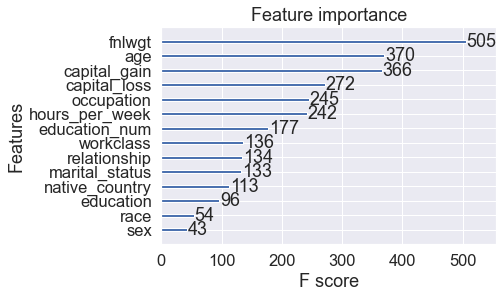

In [70]:
xgb.plot_importance(final_gb)

In [71]:
importances = final_gb.get_fscore()
importances

{'relationship': 134,
 'education_num': 177,
 'capital_gain': 366,
 'fnlwgt': 505,
 'education': 96,
 'age': 370,
 'capital_loss': 272,
 'marital_status': 133,
 'hours_per_week': 242,
 'occupation': 245,
 'workclass': 136,
 'sex': 43,
 'race': 54,
 'native_country': 113}

In [72]:
{'age': 321,
 'capital_gain': 361,
 'capital_loss': 302,
 'education': 100,
 'education_num': 174,
 'fnlwgt': 435,
 'hours_per_week': 239,
 'marital_status': 117,
 'native_country': 93,
 'occupation': 267,
 'race': 64,
 'relationship': 141,
 'sex': 42,
 'workclass': 115}

{'age': 321,
 'capital_gain': 361,
 'capital_loss': 302,
 'education': 100,
 'education_num': 174,
 'fnlwgt': 435,
 'hours_per_week': 239,
 'marital_status': 117,
 'native_country': 93,
 'occupation': 267,
 'race': 64,
 'relationship': 141,
 'sex': 42,
 'workclass': 115}

<AxesSubplot:ylabel='Feature'>

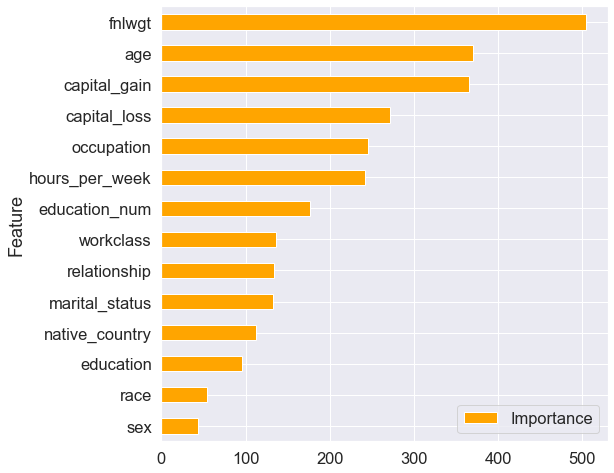

In [73]:
importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'orange')

In [74]:
testdmat = xgb.DMatrix(final_test)

In [75]:
from sklearn.metrics import accuracy_score
y_pred = final_gb.predict(testdmat) # Predict using our testdmat
y_pred

array([0.00321092, 0.210638  , 0.2636973 , ..., 0.8427599 , 0.11421108,
       0.79556805], dtype=float32)

In [76]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred

array([0., 0., 0., ..., 1., 0., 1.], dtype=float32)

In [77]:
accuracy_score(y_pred, y_test), 1-accuracy_score(y_pred, y_test)

(0.8687250996015936, 0.1312749003984064)

In [ ]:
ADR: Good! (2/2)